In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from einops import rearrange
import torch.nn.functional as F
from sklearn.metrics import classification_report, accuracy_score
from collections import Counter
import mediapipe as mp
import cv2

c:\Users\koushika\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

IMG_SIZE = 128
PATCH_SIZE = 16
EMB_SIZE = 128
DEPTH = 6
NUM_HEADS = 8
NUM_CLASSES = 5
CLASS_NAMES = ['anger', 'happiness', 'neutral', 'sadness', 'surprise']
LANDMARK_FEATURES = 468 * 2

mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1)


In [3]:
def extract_landmarks(image_tensor):
    image_np = image_tensor.permute(1, 2, 0).cpu().numpy()
    image_np = ((image_np * 0.5 + 0.5) * 255).astype(np.uint8)
    results = face_mesh.process(cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR))

    landmarks = []
    if results.multi_face_landmarks:
        for lm in results.multi_face_landmarks[0].landmark:
            landmarks.extend([lm.x, lm.y])
    else:
        landmarks = [0.0] * LANDMARK_FEATURES

    return torch.tensor(landmarks, dtype=torch.float32)

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self):
        super().__init__()
        self.projection = nn.Conv2d(3, EMB_SIZE, kernel_size=PATCH_SIZE, stride=PATCH_SIZE)
        self.cls_token = nn.Parameter(torch.randn(1, 1, EMB_SIZE))
        self.positions = nn.Parameter(torch.randn((IMG_SIZE // PATCH_SIZE) ** 2 + 1, EMB_SIZE))

    def forward(self, x):
        x = self.projection(x)
        x = rearrange(x, 'b c h w -> b (h w) c')
        cls_tokens = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.positions
        return x

In [5]:
class TransformerEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.attn = nn.MultiheadAttention(EMB_SIZE, NUM_HEADS, dropout=0.1, batch_first=True)
        self.ffn = nn.Sequential(
            nn.Linear(EMB_SIZE, EMB_SIZE * 4),
            nn.GELU(),
            nn.Linear(EMB_SIZE * 4, EMB_SIZE)
        )
        self.norm1 = nn.LayerNorm(EMB_SIZE)
        self.norm2 = nn.LayerNorm(EMB_SIZE)

    def forward(self, x):
        x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
        x = x + self.ffn(self.norm2(x))
        return x

In [6]:
class VisionTransformerWithLandmarks(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = PatchEmbedding()
        self.encoder = nn.Sequential(*[TransformerEncoder() for _ in range(DEPTH)])
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(EMB_SIZE + LANDMARK_FEATURES),
            nn.Linear(EMB_SIZE + LANDMARK_FEATURES, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, NUM_CLASSES)
        )

    def forward(self, x, landmarks):
        x = self.embedding(x)
        x = self.encoder(x)
        x_cls = x[:, 0]
        x_combined = torch.cat((x_cls, landmarks.to(x_cls.device)), dim=1)
        return self.mlp_head(x_combined)

In [7]:
def get_train_transforms():
    return transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

def get_test_transforms():
    return transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])


In [8]:
def compute_class_weights(dataset, num_classes):
    labels = [label for _, label in dataset.samples]
    class_counts = Counter(labels)
    total_samples = float(sum(class_counts.values()))
    weights = [total_samples / (num_classes * class_counts[i]) for i in range(num_classes)]
    return torch.tensor(weights, dtype=torch.float32)

In [9]:
def create_loaders(train_path, test_path):
    train_dataset = datasets.ImageFolder(train_path, transform=get_train_transforms())
    test_dataset = datasets.ImageFolder(test_path, transform=get_test_transforms())
    class_weights = compute_class_weights(train_dataset, NUM_CLASSES)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)
    return train_loader, test_loader, train_dataset.classes, class_weights


In [10]:
def visualize_predictions(model, loader, class_names, num_images=6):
    model.eval()
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    indices = np.random.choice(len(loader.dataset), num_images, replace=False)

    with torch.no_grad():
        for i, idx in enumerate(indices):
            img, label = loader.dataset[idx]
            input_img = img.unsqueeze(0).to(device)
            landmarks = extract_landmarks(img).unsqueeze(0).to(device)
            output = model(input_img, landmarks)
            probs = F.softmax(output, dim=1)
            pred = torch.argmax(probs, dim=1).item()

            img_np = img.permute(1, 2, 0).numpy() * 0.5 + 0.5
            img_np = np.clip(img_np, 0, 1)

            ax = axs[i // 3, i % 3]
            ax.imshow(img_np)
            ax.set_title(f"True: {class_names[label]}\nPred: {class_names[pred]}\nConf: {probs[0][pred]:.2f}")
            ax.axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
def evaluate(model, loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            landmarks_batch = torch.stack([extract_landmarks(img) for img in images]).to(device)
            outputs = model(images, landmarks_batch)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    print(f"\n Overall Accuracy: {acc * 100:.2f}%")
    print("\n" + classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))
    return acc


In [ ]:
def train_model(train_path, test_path, num_epochs=25):
    train_loader, test_loader, _, class_weights = create_loaders(train_path, test_path)
    model = VisionTransformerWithLandmarks().to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    optimizer = optim.AdamW(model.parameters(), lr=3e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)

    losses = []
    accuracies = []
    best_loss = float('inf')

    print(" Initial Evaluation:")
    acc = evaluate(model, test_loader, CLASS_NAMES)
    accuracies.append(acc)
    visualize_predictions(model, test_loader, CLASS_NAMES)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        progress = tqdm(train_loader, desc=f"Epoch {epoch + 1}")

        for images, labels in progress:
            images, labels = images.to(device), labels.to(device)
            landmarks_batch = torch.stack([extract_landmarks(img) for img in images]).to(device)

            optimizer.zero_grad()
            outputs = model(images, landmarks_batch)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            progress.set_postfix(loss=loss.item())

        scheduler.step()
        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch + 1} Loss: {avg_loss:.4f}")

        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(model.state_dict(), "best_model_5class.pth")
            print("✅ Model checkpoint saved (best so far)")

        if (epoch + 1) % 2 == 0:
            print(f"\n📊 Evaluation after epoch {epoch + 1}:")
            acc = evaluate(model, test_loader, CLASS_NAMES)
            accuracies.append(acc)
            visualize_predictions(model, test_loader, CLASS_NAMES)

    # Plot loss
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, num_epochs + 1), losses, marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Training Loss")
    plt.title("Training Loss Over Epochs")
    plt.grid(True)
    plt.show()

    # Plot accuracy
    plt.figure(figsize=(8, 4))
    plt.plot([0] + list(range(2, num_epochs + 1, 2)), accuracies, marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Test Accuracy")
    plt.title("Test Accuracy Over Epochs")
    plt.grid(True)
    plt.show()


🔍 Initial Evaluation:

✅ Overall Accuracy: 20.05%

              precision    recall  f1-score   support

       anger       0.10      0.00      0.00       800
   happiness       0.00      0.00      0.00       800
     neutral       0.00      0.00      0.00       800
     sadness       0.00      0.00      0.00       800
    surprise       0.20      1.00      0.33       800

    accuracy                           0.20      4000
   macro avg       0.06      0.20      0.07      4000
weighted avg       0.06      0.20      0.07      4000



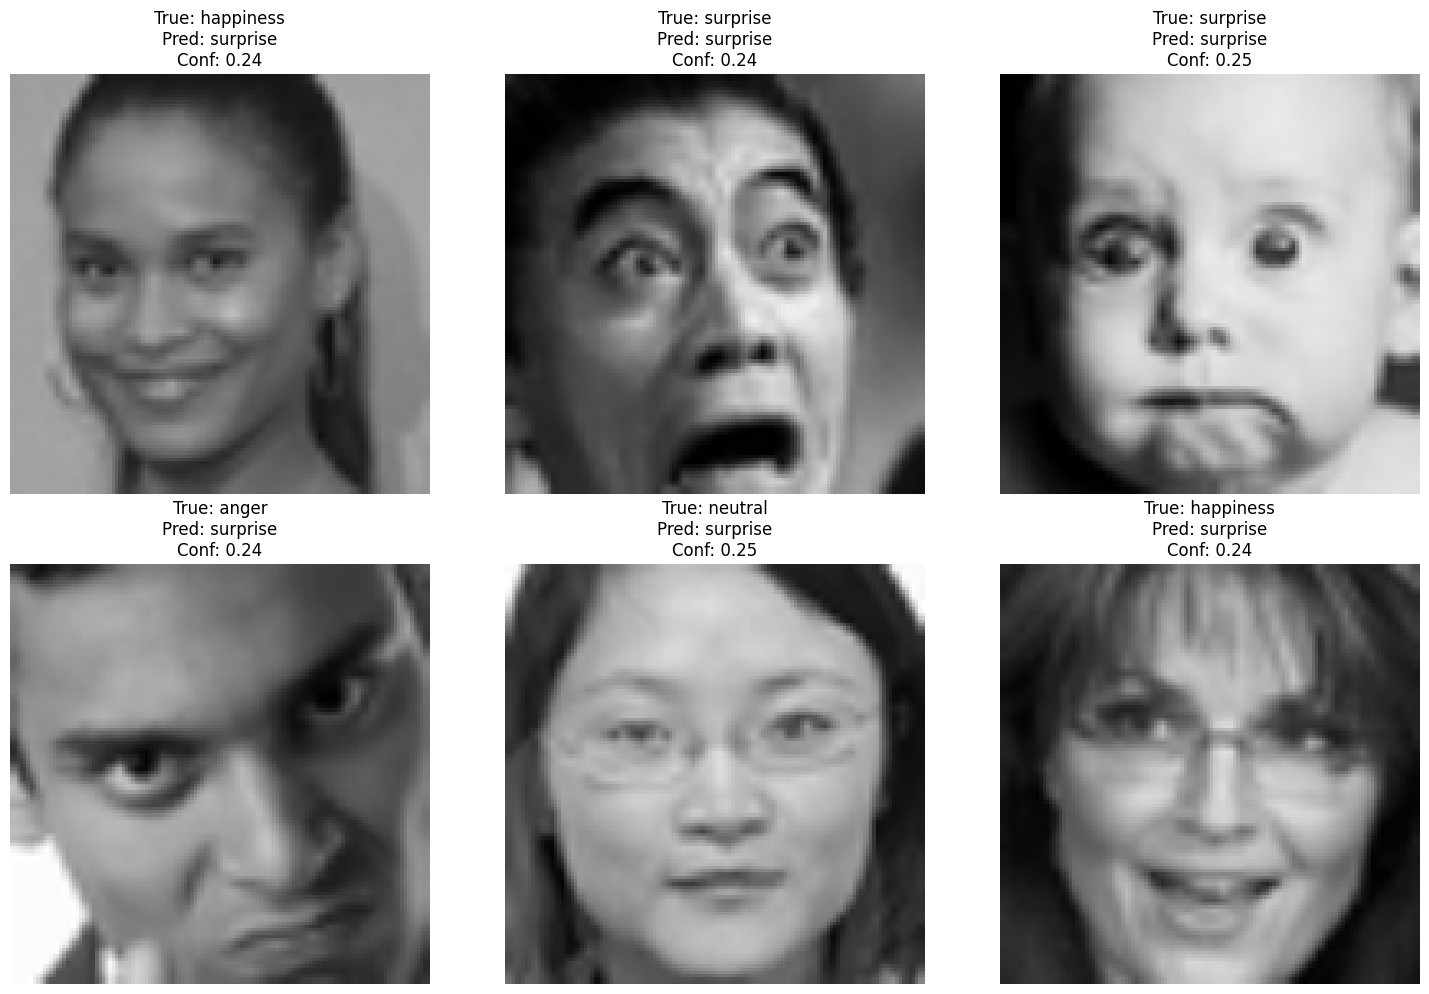

Epoch 1: 100%|██████████| 625/625 [05:18<00:00,  1.96it/s, loss=1.4] 


Epoch 1 Loss: 1.5338
✅ Model checkpoint saved (best so far)


Epoch 2: 100%|██████████| 625/625 [06:45<00:00,  1.54it/s, loss=1.32]


Epoch 2 Loss: 1.3133
✅ Model checkpoint saved (best so far)

📊 Evaluation after epoch 2:

✅ Overall Accuracy: 47.38%

              precision    recall  f1-score   support

       anger       0.59      0.10      0.17       800
   happiness       0.47      0.88      0.61       800
     neutral       0.38      0.63      0.48       800
     sadness       0.35      0.23      0.28       800
    surprise       0.81      0.52      0.64       800

    accuracy                           0.47      4000
   macro avg       0.52      0.47      0.44      4000
weighted avg       0.52      0.47      0.44      4000



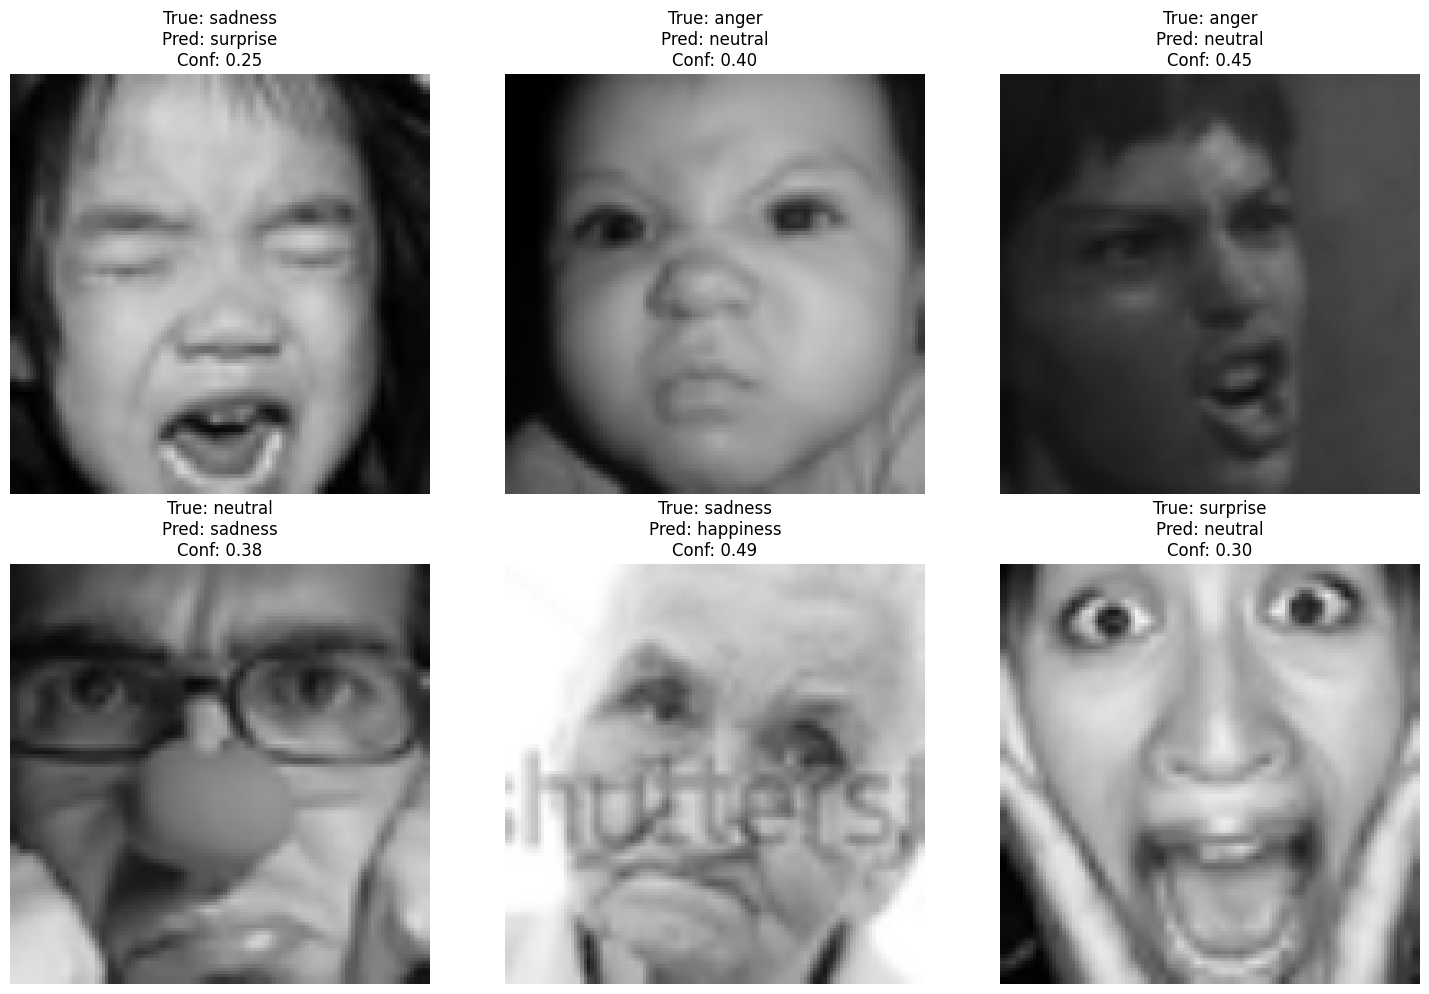

Epoch 3: 100%|██████████| 625/625 [06:10<00:00,  1.69it/s, loss=1.34] 


Epoch 3 Loss: 1.2281
✅ Model checkpoint saved (best so far)


Epoch 4: 100%|██████████| 625/625 [07:25<00:00,  1.40it/s, loss=1.21] 


Epoch 4 Loss: 1.1737
✅ Model checkpoint saved (best so far)

📊 Evaluation after epoch 4:

✅ Overall Accuracy: 55.10%

              precision    recall  f1-score   support

       anger       0.49      0.45      0.47       800
   happiness       0.70      0.77      0.73       800
     neutral       0.45      0.57      0.50       800
     sadness       0.37      0.22      0.28       800
    surprise       0.68      0.74      0.71       800

    accuracy                           0.55      4000
   macro avg       0.54      0.55      0.54      4000
weighted avg       0.54      0.55      0.54      4000



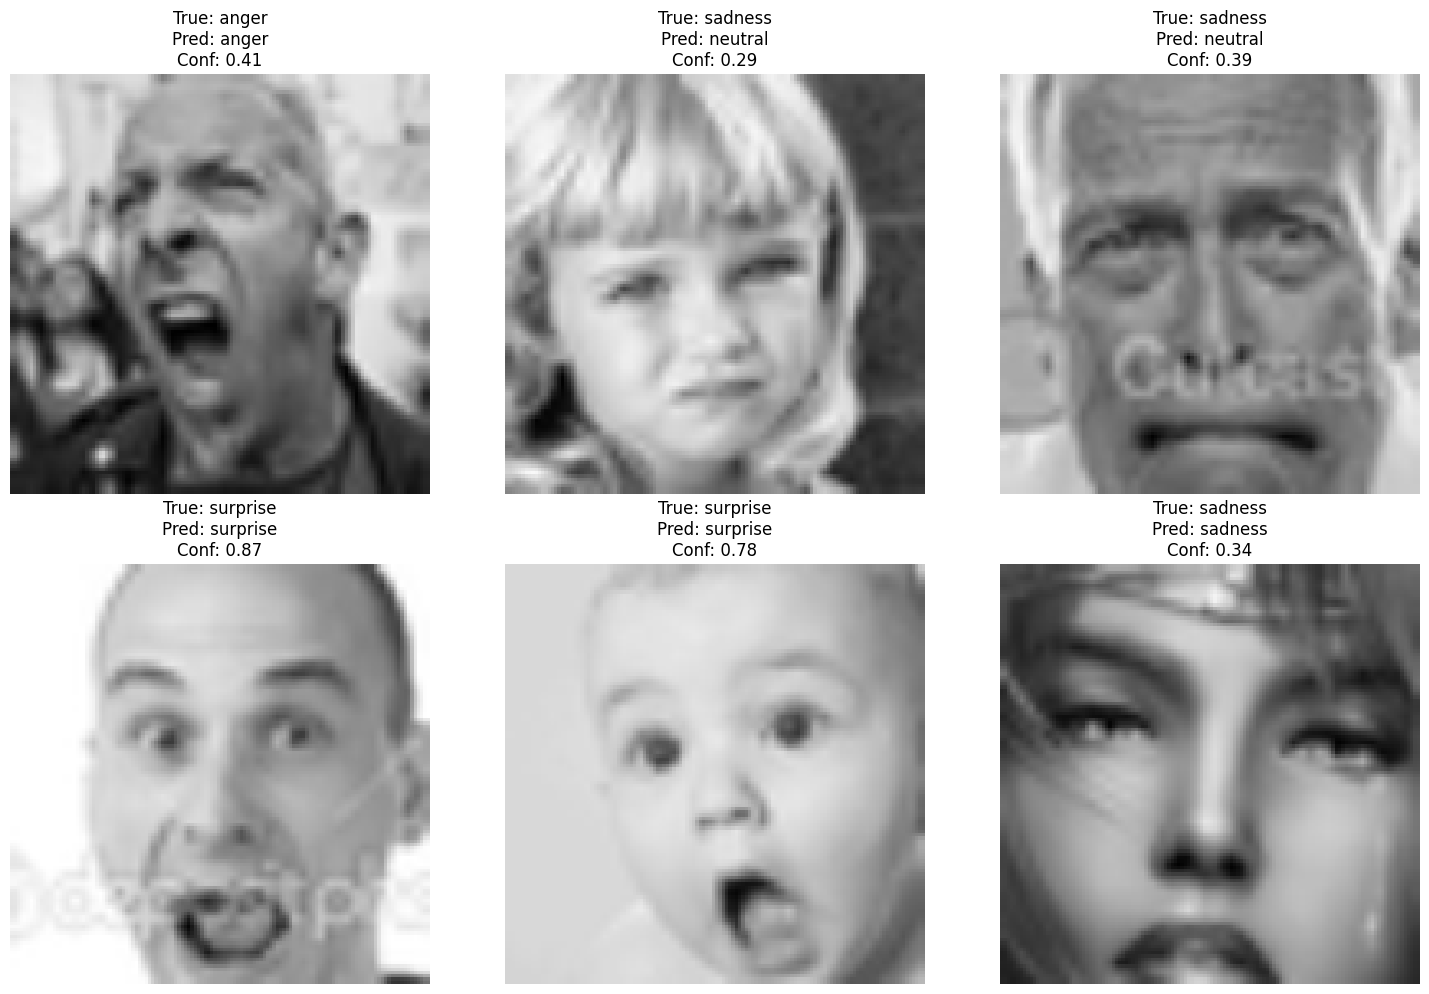

Epoch 5: 100%|██████████| 625/625 [07:31<00:00,  1.38it/s, loss=0.877]


Epoch 5 Loss: 1.1281
✅ Model checkpoint saved (best so far)


Epoch 6: 100%|██████████| 625/625 [07:52<00:00,  1.32it/s, loss=0.993]


Epoch 6 Loss: 1.0836
✅ Model checkpoint saved (best so far)

📊 Evaluation after epoch 6:

✅ Overall Accuracy: 59.80%

              precision    recall  f1-score   support

       anger       0.56      0.47      0.51       800
   happiness       0.65      0.85      0.74       800
     neutral       0.52      0.58      0.55       800
     sadness       0.51      0.29      0.37       800
    surprise       0.68      0.79      0.73       800

    accuracy                           0.60      4000
   macro avg       0.58      0.60      0.58      4000
weighted avg       0.58      0.60      0.58      4000



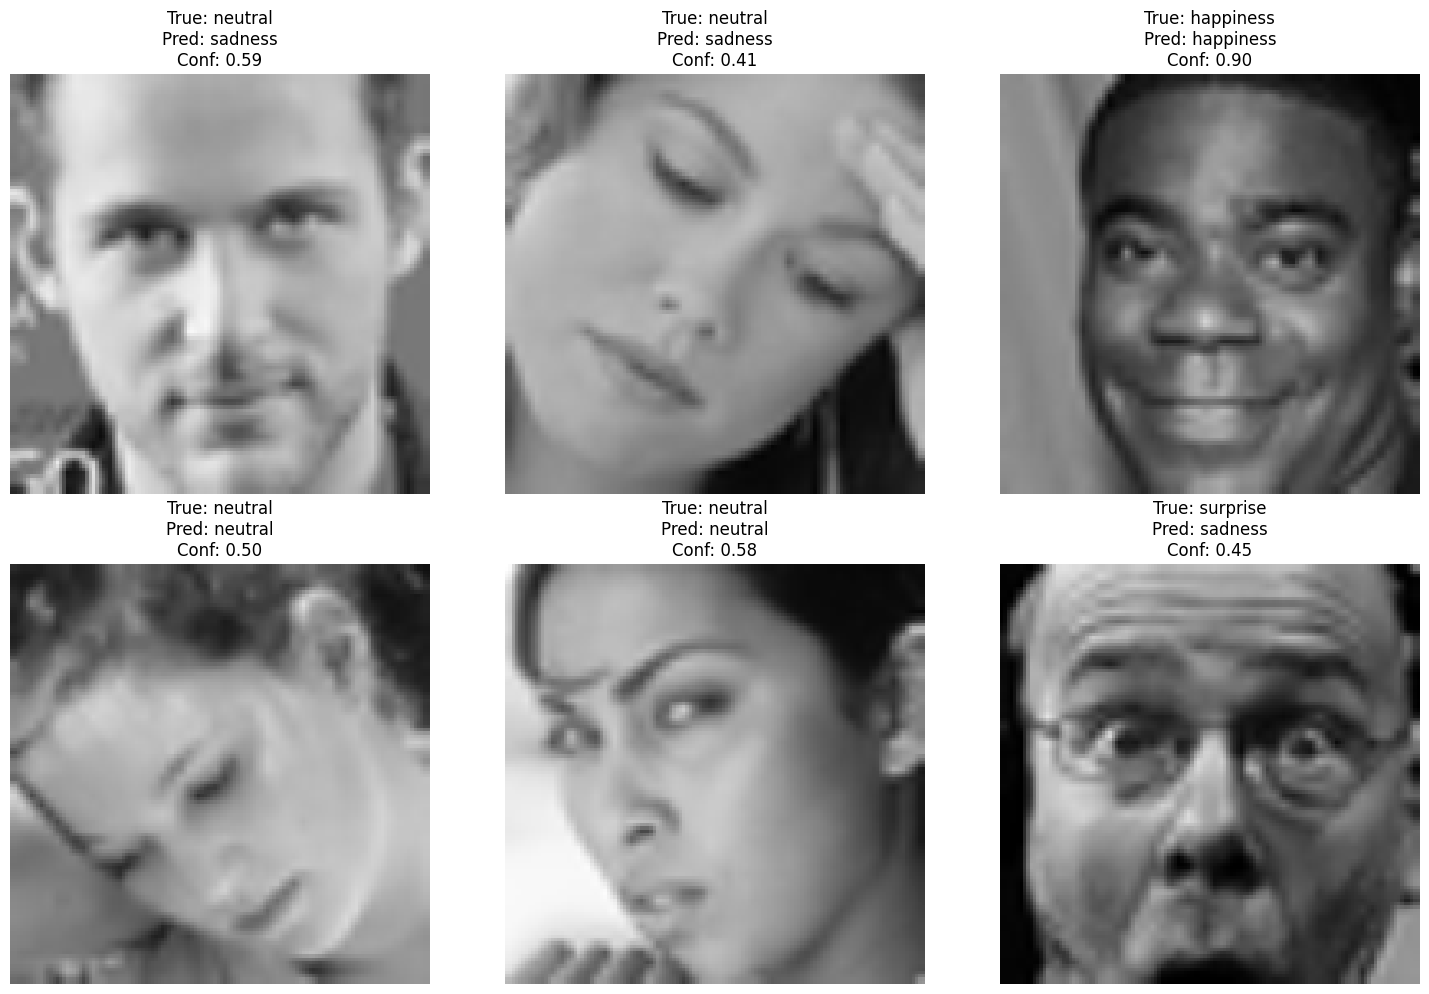

Epoch 7: 100%|██████████| 625/625 [06:13<00:00,  1.67it/s, loss=0.979]


Epoch 7 Loss: 1.0570
✅ Model checkpoint saved (best so far)


Epoch 8: 100%|██████████| 625/625 [05:28<00:00,  1.90it/s, loss=1]    


Epoch 8 Loss: 1.0373
✅ Model checkpoint saved (best so far)

📊 Evaluation after epoch 8:

✅ Overall Accuracy: 60.82%

              precision    recall  f1-score   support

       anger       0.57      0.55      0.56       800
   happiness       0.74      0.79      0.76       800
     neutral       0.54      0.49      0.51       800
     sadness       0.48      0.38      0.42       800
    surprise       0.66      0.83      0.73       800

    accuracy                           0.61      4000
   macro avg       0.60      0.61      0.60      4000
weighted avg       0.60      0.61      0.60      4000



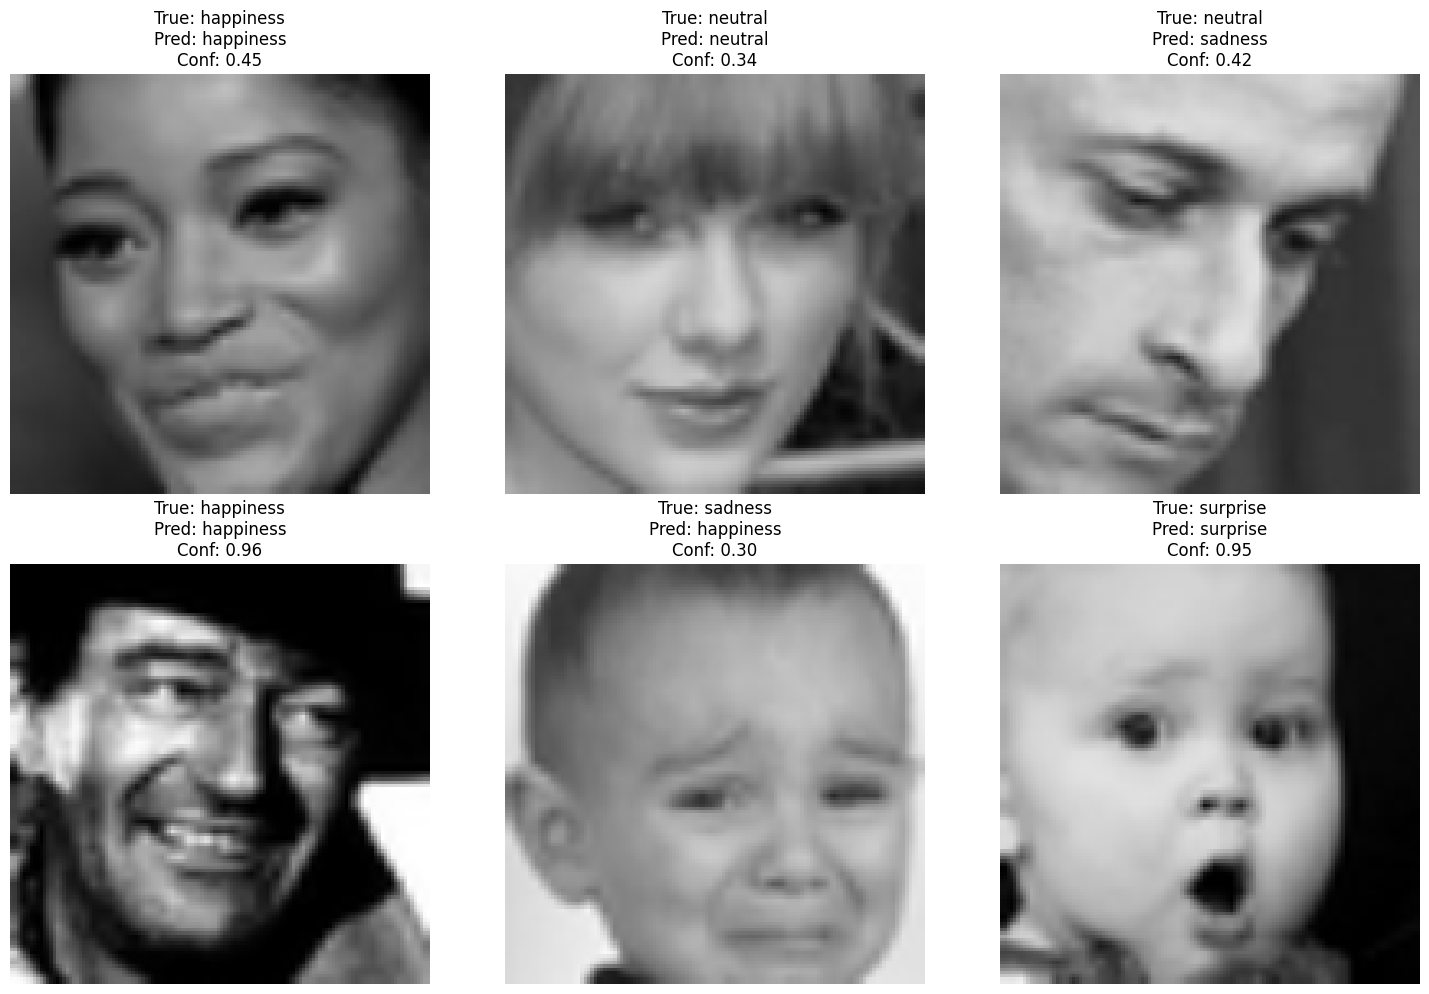

Epoch 9: 100%|██████████| 625/625 [05:29<00:00,  1.89it/s, loss=1.07] 


Epoch 9 Loss: 1.0202
✅ Model checkpoint saved (best so far)


Epoch 10: 100%|██████████| 625/625 [05:18<00:00,  1.96it/s, loss=0.955]


Epoch 10 Loss: 1.0036
✅ Model checkpoint saved (best so far)

📊 Evaluation after epoch 10:

✅ Overall Accuracy: 61.82%

              precision    recall  f1-score   support

       anger       0.58      0.56      0.57       800
   happiness       0.79      0.75      0.77       800
     neutral       0.53      0.57      0.55       800
     sadness       0.46      0.44      0.45       800
    surprise       0.73      0.78      0.75       800

    accuracy                           0.62      4000
   macro avg       0.62      0.62      0.62      4000
weighted avg       0.62      0.62      0.62      4000



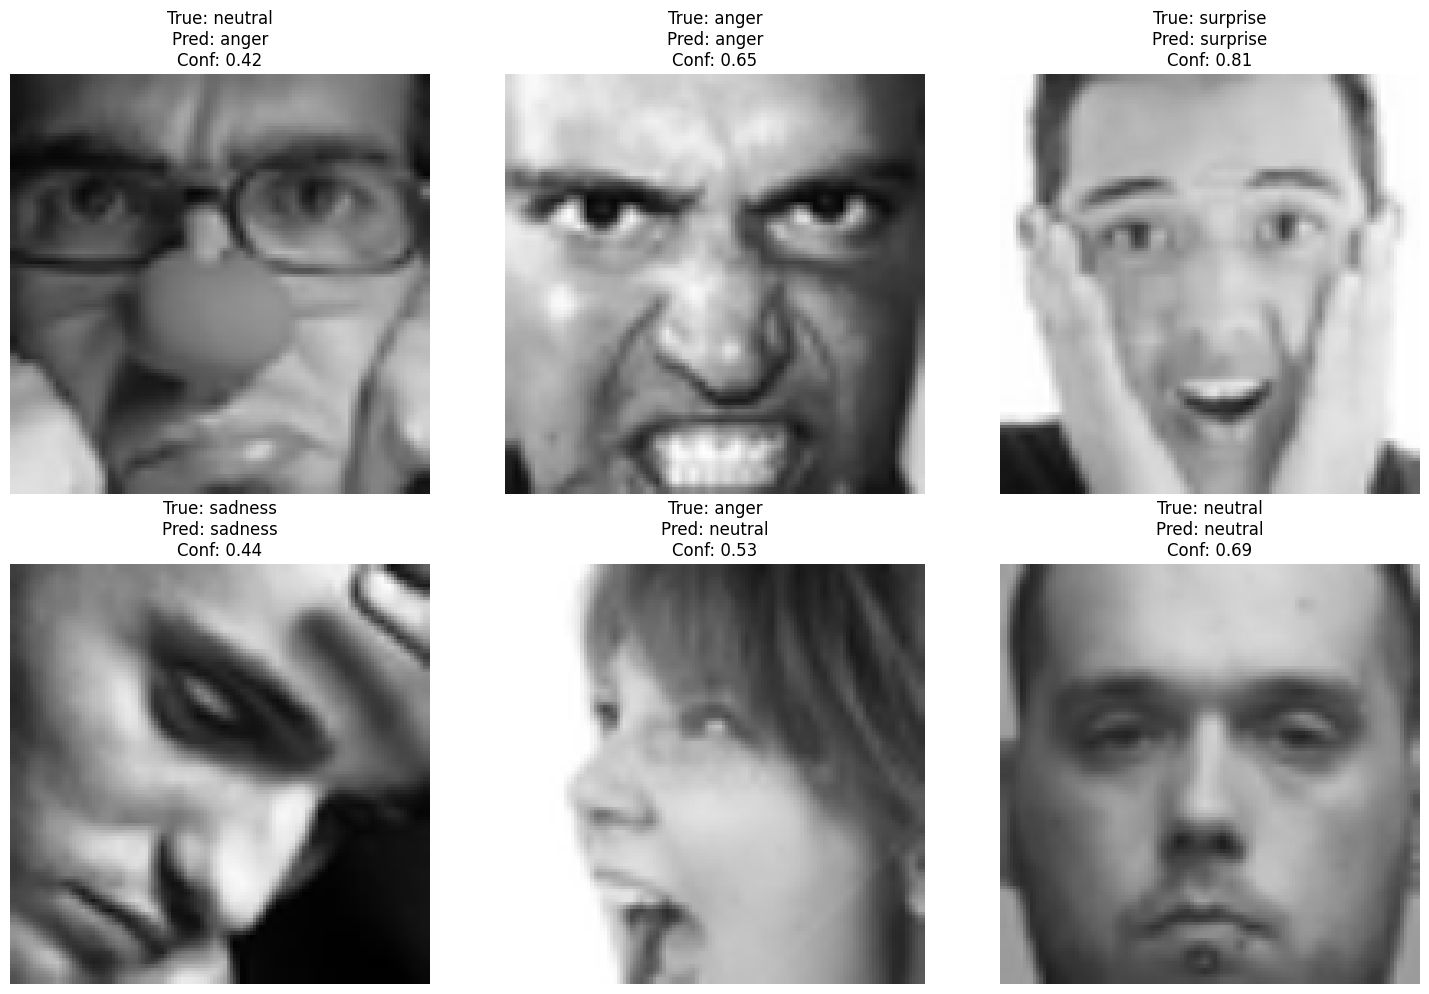

Epoch 11: 100%|██████████| 625/625 [05:37<00:00,  1.85it/s, loss=1.07] 


Epoch 11 Loss: 0.9711
✅ Model checkpoint saved (best so far)


Epoch 12: 100%|██████████| 625/625 [05:32<00:00,  1.88it/s, loss=0.829]


Epoch 12 Loss: 0.9560
✅ Model checkpoint saved (best so far)

📊 Evaluation after epoch 12:

✅ Overall Accuracy: 64.18%

              precision    recall  f1-score   support

       anger       0.63      0.55      0.59       800
   happiness       0.77      0.79      0.78       800
     neutral       0.53      0.62      0.57       800
     sadness       0.49      0.51      0.50       800
    surprise       0.81      0.74      0.77       800

    accuracy                           0.64      4000
   macro avg       0.65      0.64      0.64      4000
weighted avg       0.65      0.64      0.64      4000



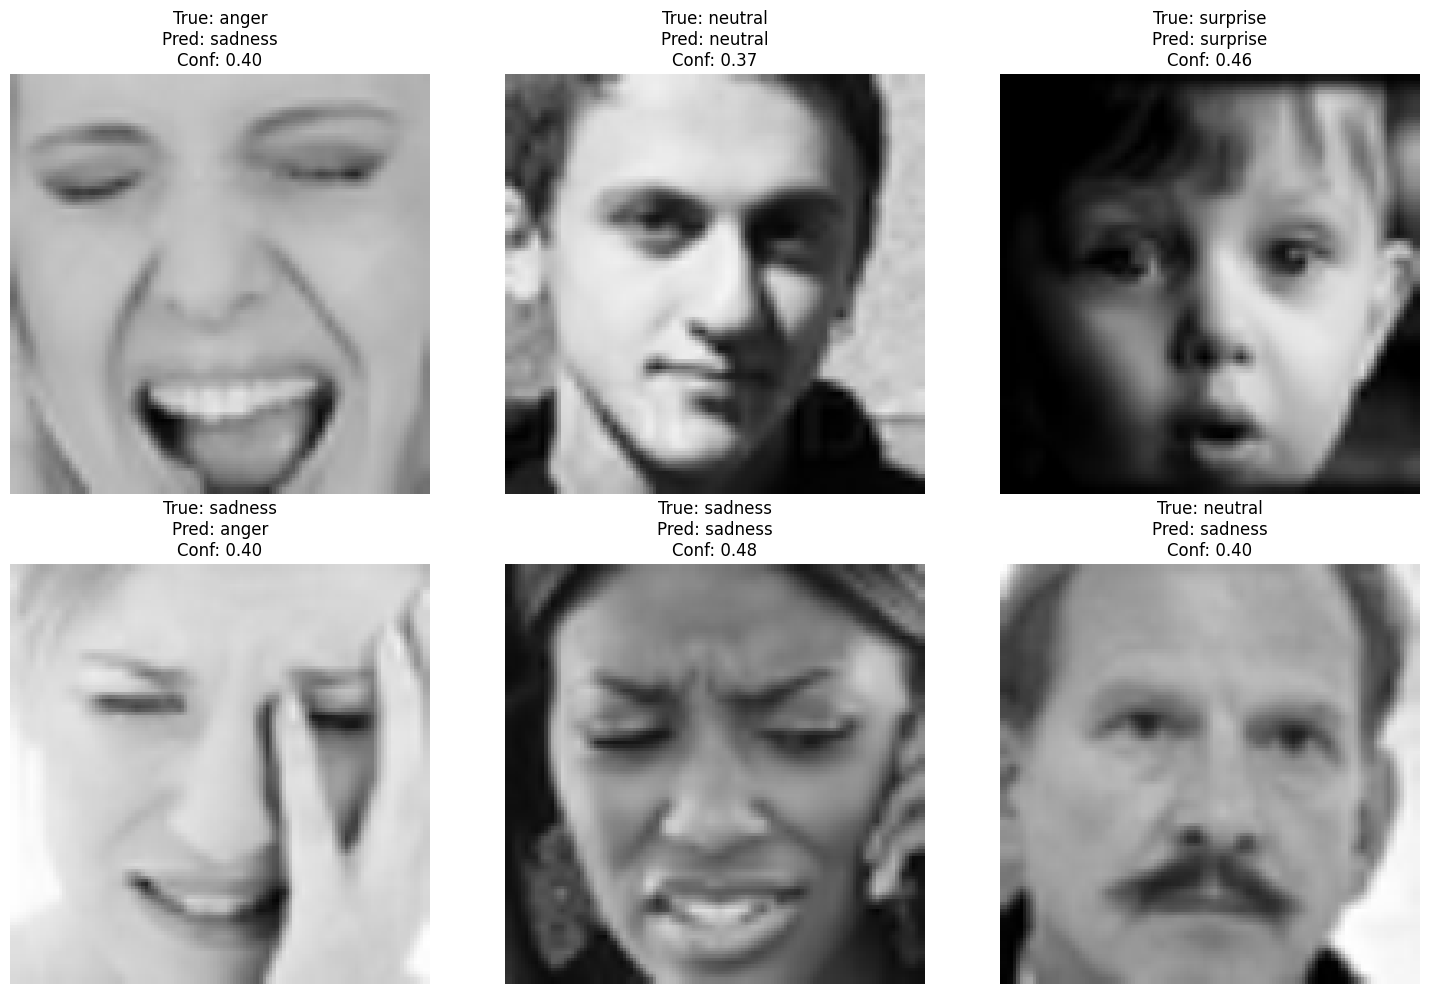

Epoch 13: 100%|██████████| 625/625 [05:36<00:00,  1.86it/s, loss=1.08] 


Epoch 13 Loss: 0.9491
✅ Model checkpoint saved (best so far)


Epoch 14: 100%|██████████| 625/625 [05:32<00:00,  1.88it/s, loss=0.751]


Epoch 14 Loss: 0.9345
✅ Model checkpoint saved (best so far)

📊 Evaluation after epoch 14:

✅ Overall Accuracy: 66.03%

              precision    recall  f1-score   support

       anger       0.67      0.57      0.62       800
   happiness       0.78      0.80      0.79       800
     neutral       0.56      0.61      0.59       800
     sadness       0.52      0.52      0.52       800
    surprise       0.78      0.80      0.79       800

    accuracy                           0.66      4000
   macro avg       0.66      0.66      0.66      4000
weighted avg       0.66      0.66      0.66      4000



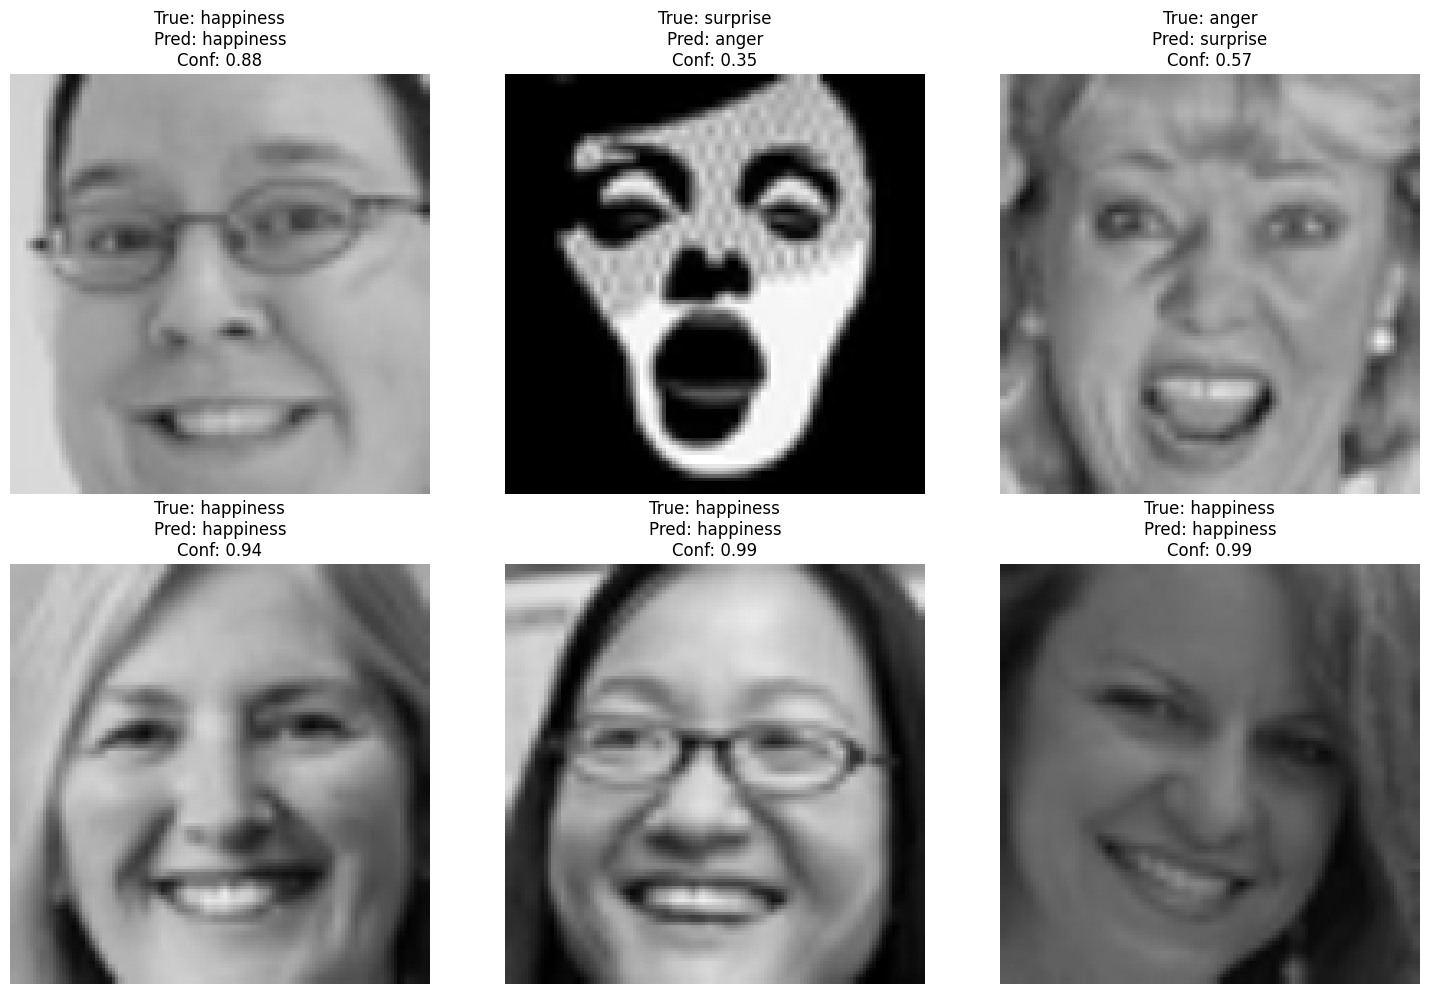

Epoch 15: 100%|██████████| 625/625 [05:54<00:00,  1.76it/s, loss=0.904]


Epoch 15 Loss: 0.9199
✅ Model checkpoint saved (best so far)


Epoch 16: 100%|██████████| 625/625 [05:45<00:00,  1.81it/s, loss=0.842]


Epoch 16 Loss: 0.8917
✅ Model checkpoint saved (best so far)

📊 Evaluation after epoch 16:

✅ Overall Accuracy: 65.92%

              precision    recall  f1-score   support

       anger       0.59      0.68      0.63       800
   happiness       0.81      0.79      0.80       800
     neutral       0.59      0.55      0.57       800
     sadness       0.51      0.57      0.53       800
    surprise       0.86      0.71      0.78       800

    accuracy                           0.66      4000
   macro avg       0.67      0.66      0.66      4000
weighted avg       0.67      0.66      0.66      4000



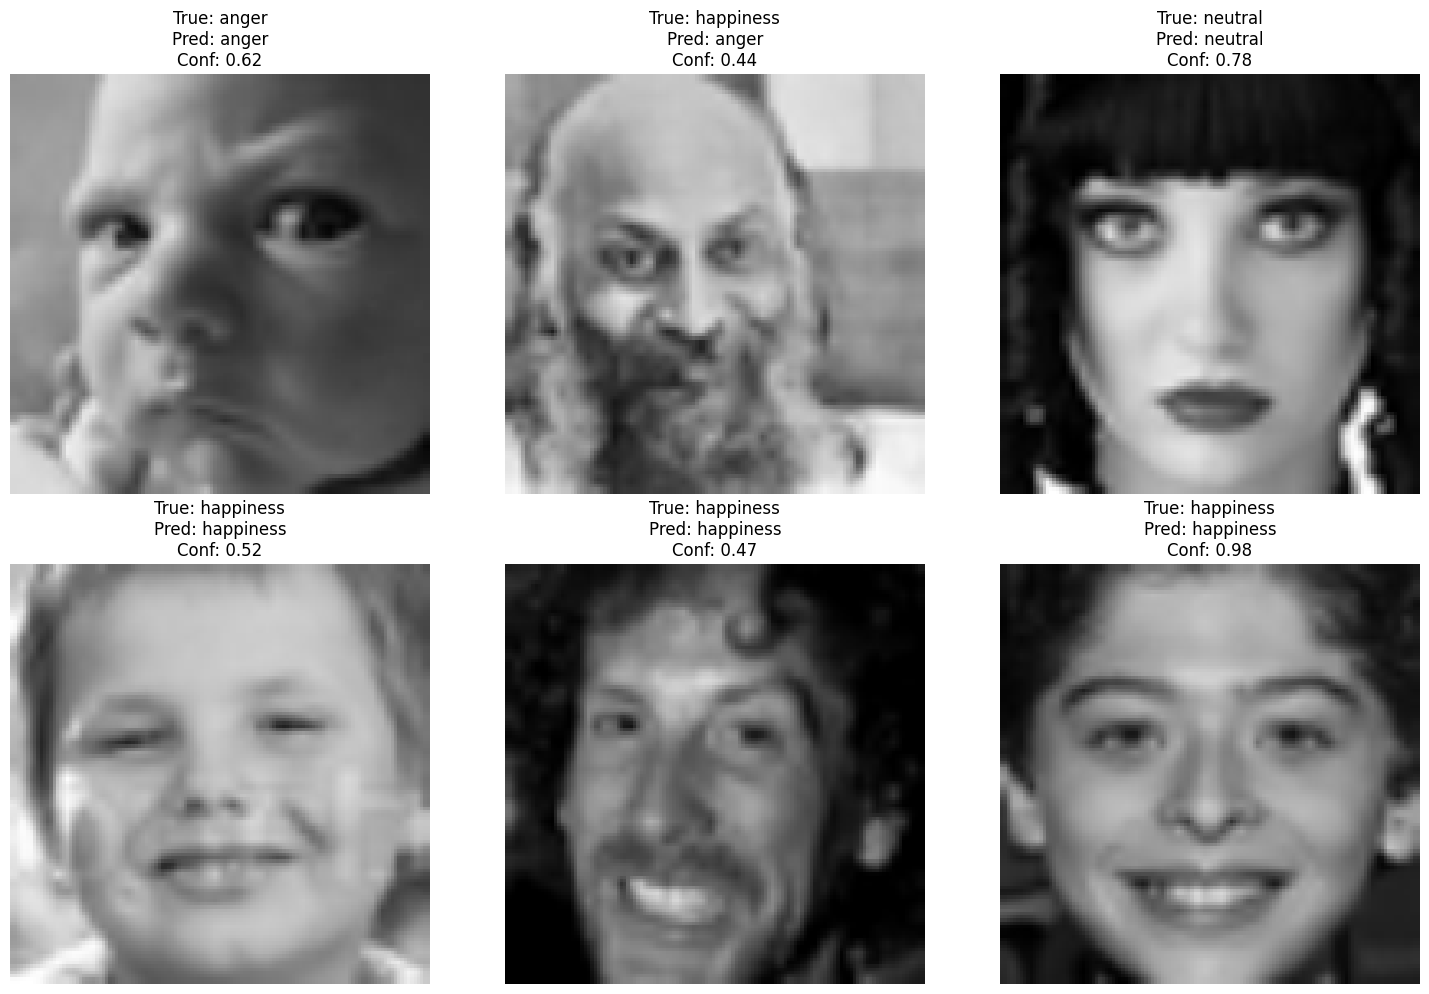

Epoch 17: 100%|██████████| 625/625 [05:27<00:00,  1.91it/s, loss=0.808]


Epoch 17 Loss: 0.8766
✅ Model checkpoint saved (best so far)


Epoch 18: 100%|██████████| 625/625 [06:21<00:00,  1.64it/s, loss=0.979]


Epoch 18 Loss: 0.8665
✅ Model checkpoint saved (best so far)

📊 Evaluation after epoch 18:

✅ Overall Accuracy: 66.20%

              precision    recall  f1-score   support

       anger       0.69      0.55      0.61       800
   happiness       0.84      0.76      0.80       800
     neutral       0.57      0.58      0.57       800
     sadness       0.48      0.65      0.55       800
    surprise       0.83      0.76      0.80       800

    accuracy                           0.66      4000
   macro avg       0.68      0.66      0.67      4000
weighted avg       0.68      0.66      0.67      4000



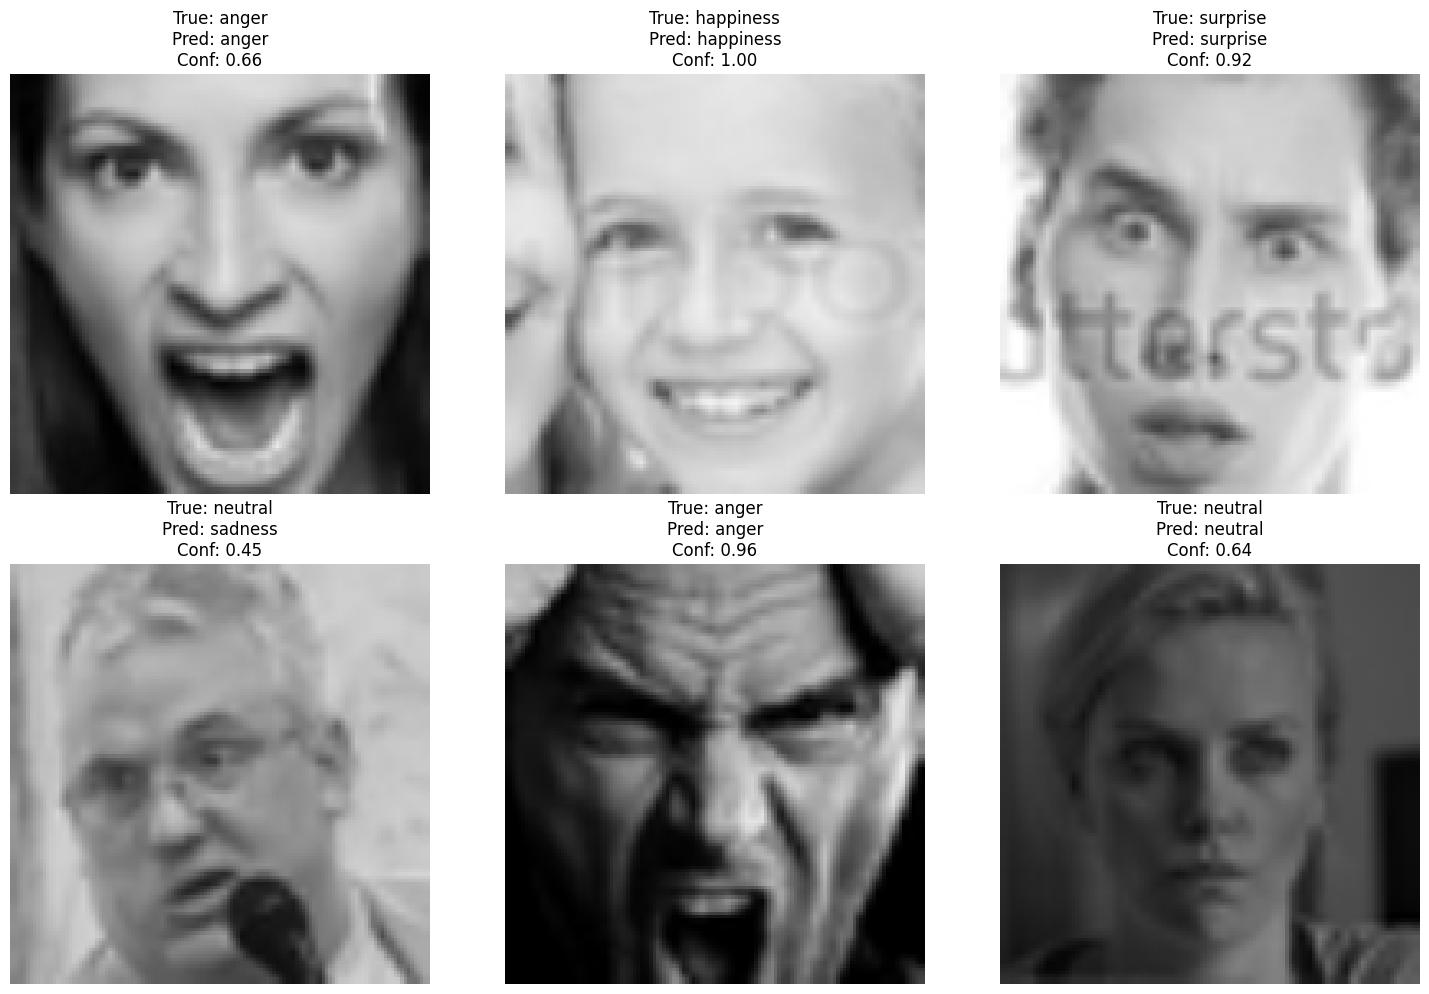

Epoch 19: 100%|██████████| 625/625 [06:56<00:00,  1.50it/s, loss=1.15] 


Epoch 19 Loss: 0.8572
✅ Model checkpoint saved (best so far)


Epoch 20: 100%|██████████| 625/625 [07:06<00:00,  1.47it/s, loss=0.764]


Epoch 20 Loss: 0.8474
✅ Model checkpoint saved (best so far)

📊 Evaluation after epoch 20:

✅ Overall Accuracy: 67.22%

              precision    recall  f1-score   support

       anger       0.69      0.59      0.63       800
   happiness       0.78      0.82      0.80       800
     neutral       0.54      0.71      0.61       800
     sadness       0.61      0.43      0.50       800
    surprise       0.76      0.81      0.79       800

    accuracy                           0.67      4000
   macro avg       0.68      0.67      0.67      4000
weighted avg       0.68      0.67      0.67      4000



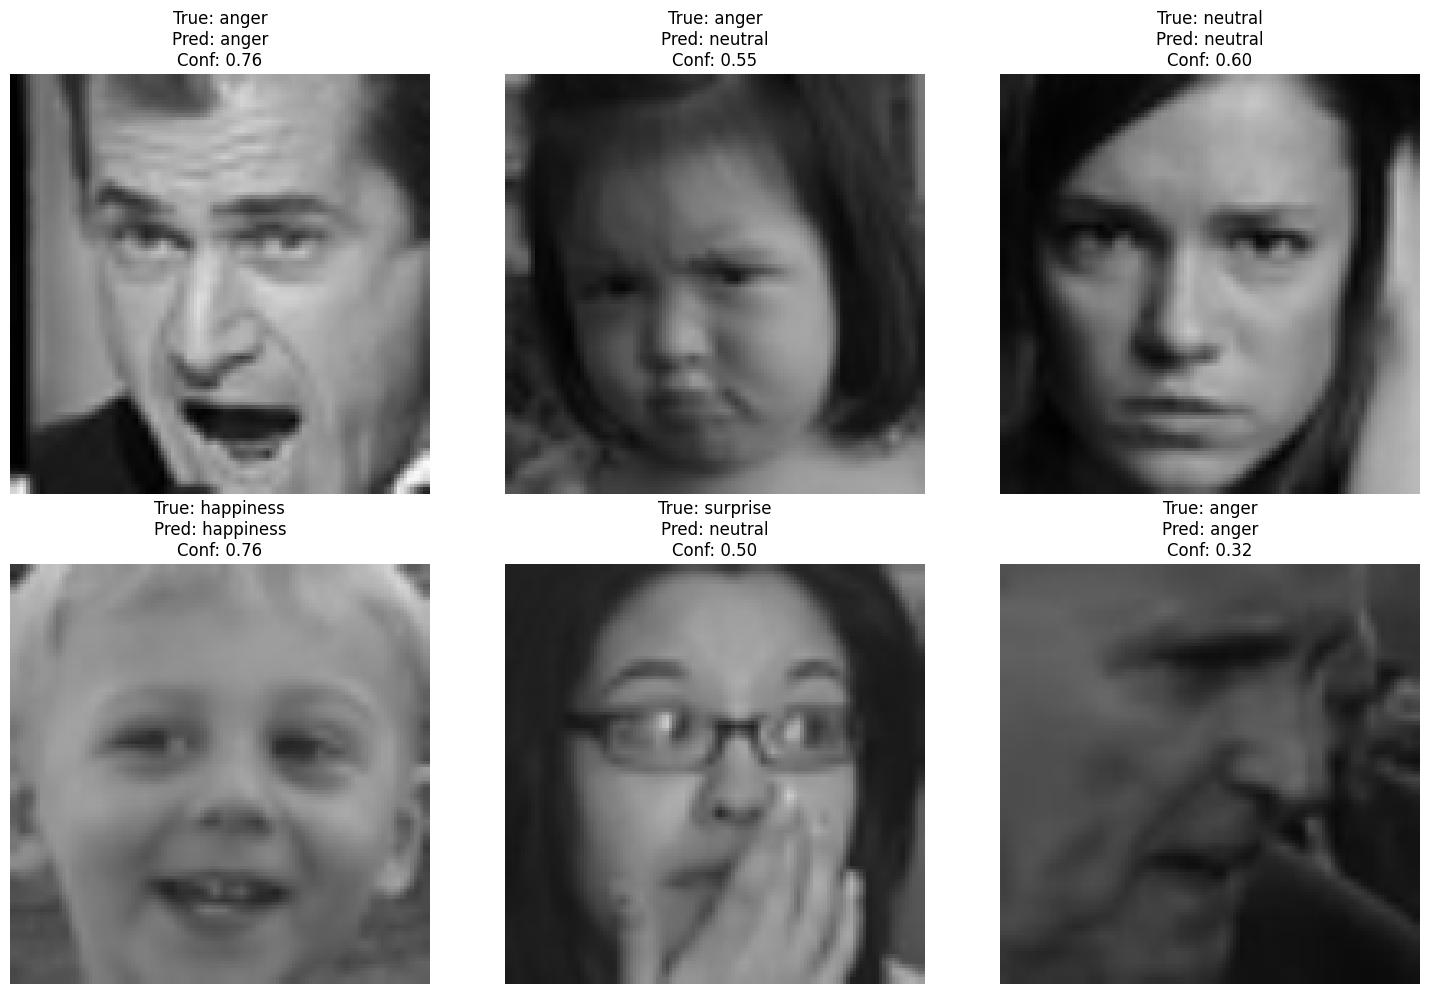

Epoch 21: 100%|██████████| 625/625 [06:46<00:00,  1.54it/s, loss=0.769]


Epoch 21 Loss: 0.8195
✅ Model checkpoint saved (best so far)


Epoch 22: 100%|██████████| 625/625 [06:12<00:00,  1.68it/s, loss=0.673]


Epoch 22 Loss: 0.8074
✅ Model checkpoint saved (best so far)

📊 Evaluation after epoch 22:

✅ Overall Accuracy: 67.38%

              precision    recall  f1-score   support

       anger       0.73      0.57      0.64       800
   happiness       0.78      0.82      0.80       800
     neutral       0.56      0.61      0.58       800
     sadness       0.54      0.55      0.54       800
    surprise       0.76      0.82      0.79       800

    accuracy                           0.67      4000
   macro avg       0.68      0.67      0.67      4000
weighted avg       0.68      0.67      0.67      4000



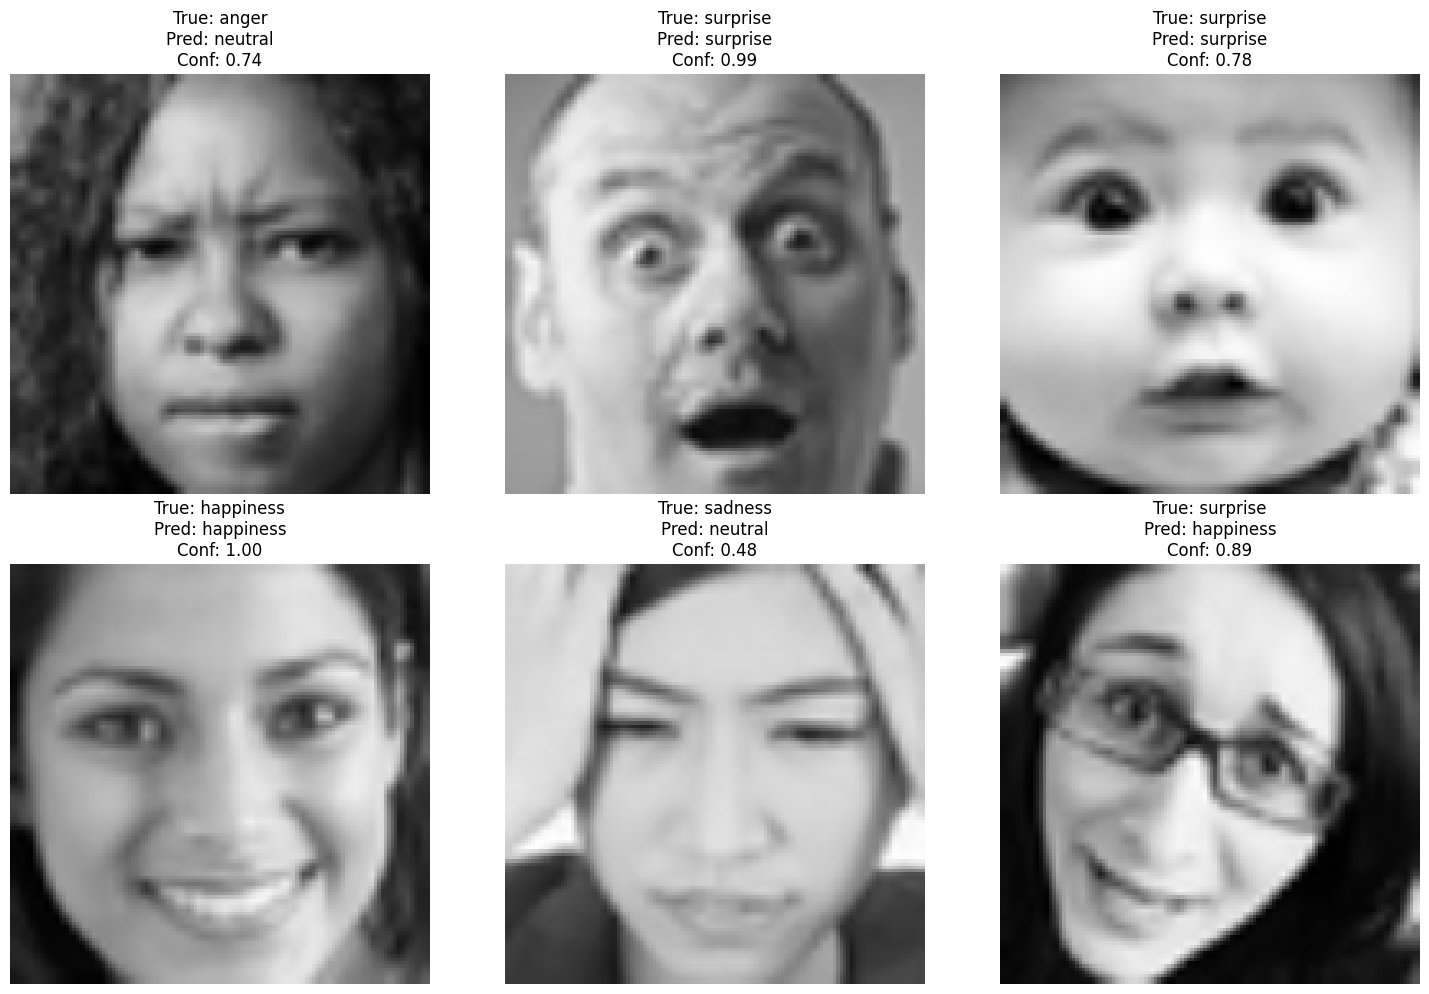

Epoch 23: 100%|██████████| 625/625 [05:12<00:00,  2.00it/s, loss=0.868]


Epoch 23 Loss: 0.7992
✅ Model checkpoint saved (best so far)


Epoch 24: 100%|██████████| 625/625 [05:24<00:00,  1.93it/s, loss=0.885]


Epoch 24 Loss: 0.7916
✅ Model checkpoint saved (best so far)

📊 Evaluation after epoch 24:

✅ Overall Accuracy: 66.95%

              precision    recall  f1-score   support

       anger       0.70      0.59      0.64       800
   happiness       0.77      0.81      0.79       800
     neutral       0.58      0.59      0.58       800
     sadness       0.52      0.56      0.54       800
    surprise       0.79      0.80      0.80       800

    accuracy                           0.67      4000
   macro avg       0.67      0.67      0.67      4000
weighted avg       0.67      0.67      0.67      4000



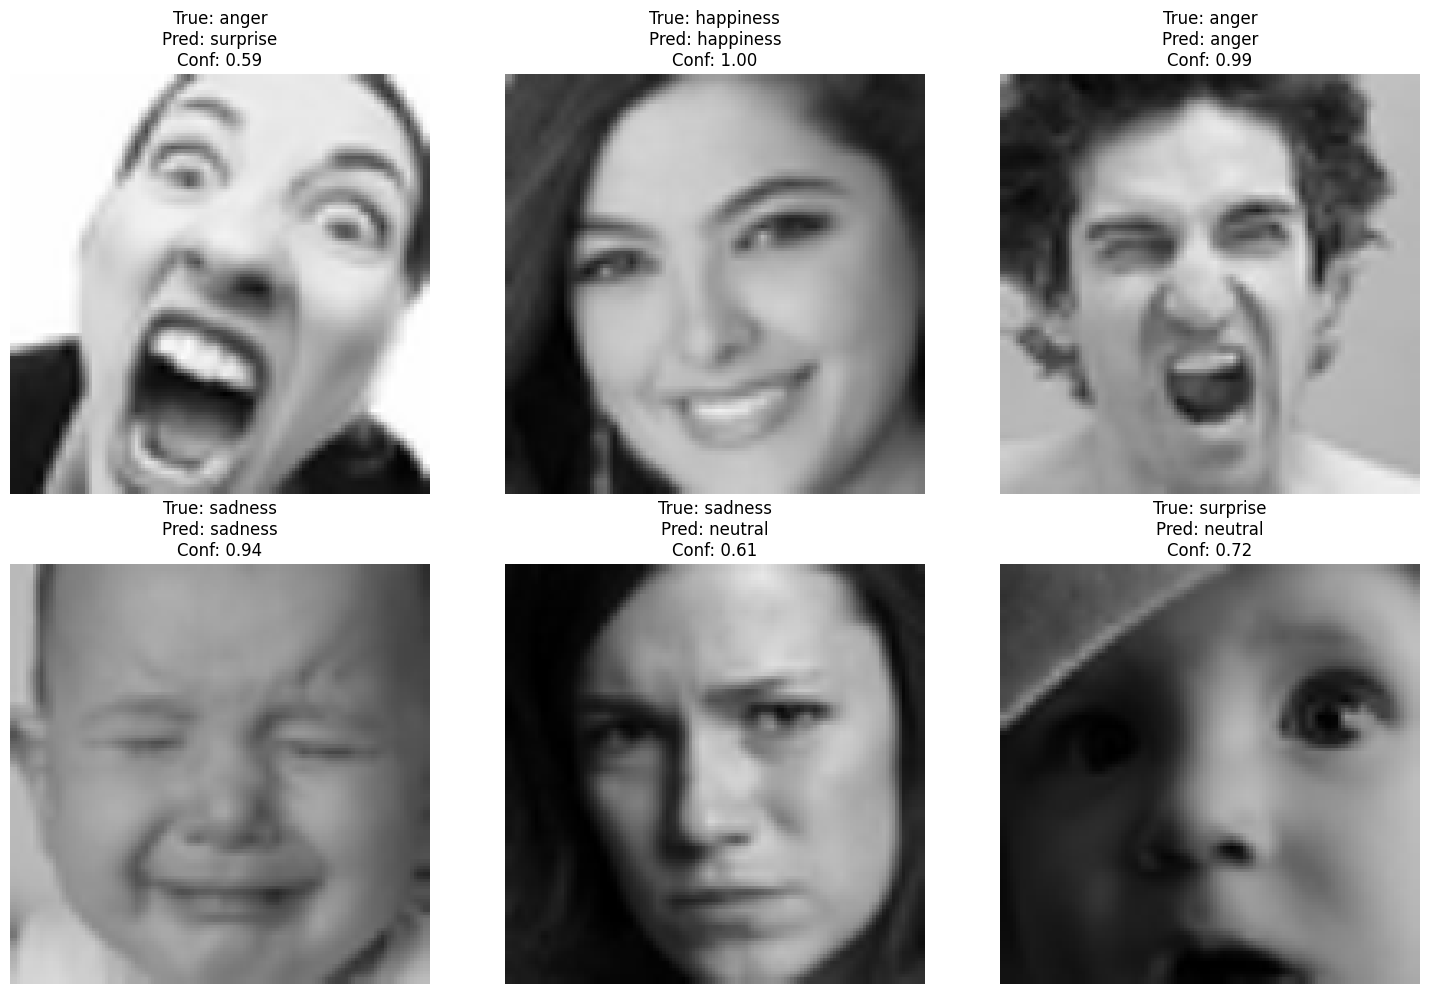

Epoch 25: 100%|██████████| 625/625 [05:11<00:00,  2.00it/s, loss=0.92] 

Epoch 25 Loss: 0.7787
✅ Model checkpoint saved (best so far)


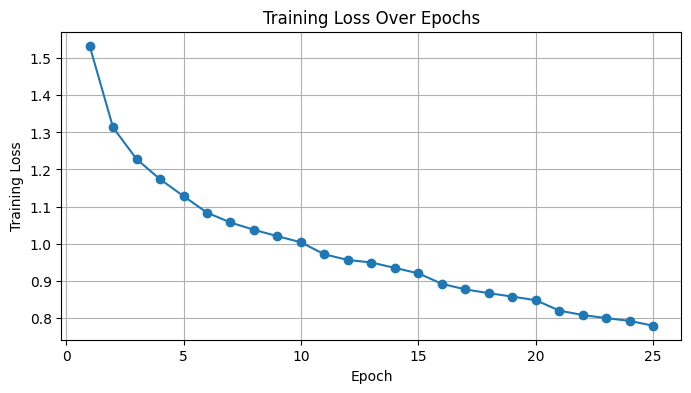

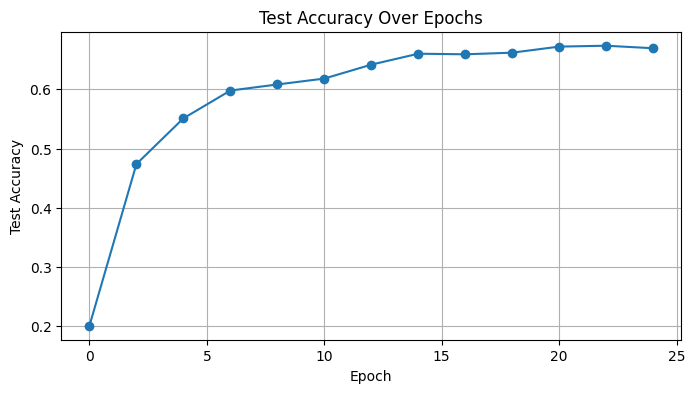

In [13]:
if __name__ == "__main__":
    train_path = r"C:/Users/koushika/Dropbox/PC/Downloads/FERPlus-master/FERPlus_Balanced_5Class/train"
    test_path = r"C:/Users/koushika/Dropbox/PC/Downloads/FERPlus-master/FERPlus_Balanced_5Class/test"
    train_model(train_path, test_path, num_epochs=25)